In [1]:
import ldc.waveform.fastGB as FB
from ldc.lisa import orbits
from astropy import units as un
import numpy as np
#from memory_profiler import profile
import fastGB as FB_MLDC
import matplotlib.pyplot as plt
import math

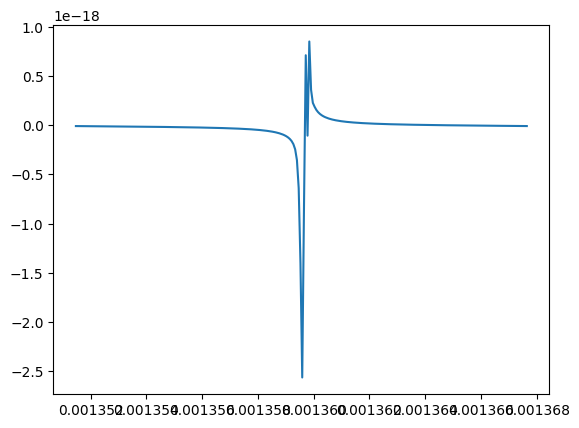

In [26]:
#data_generation
pGB = dict({'Amplitude': 1.07345e-22,# "strain"
            'EclipticLatitude': 0.312414, # "radian"
            'EclipticLongitude': -2.75291,# "radian"
            'Frequency': 0.00135962, #"Hz"
            'FrequencyDerivative': 8.94581279e-19,# "Hz^2"
            'Inclination': 0.523599,# "radian"
            'InitialPhase': 3.0581565, #"radian"
            'Polarization': 3.5621656}) #"radian"

#@profile
# def loop(prm, Tobs, del_t):
#     GB = FB.FastGB(delta_t=15, T=365*24*60*60) # in seconds

#     for i in range(10000):
#         freqT, X, Y, Z = GB.get_fd_tdixyz(template=pGB,
#                                           oversample=4,
#                                           simulator='synthlisa')
#     return 0

#loop(prm, Tobs, del_t)

del_t = 15
Tobs = 365*24*60*60*0.5
lisa_orbits = orbits.Orbits.type(dict({"nominal_arm_length":2.5e6*un.km,
                                       "initial_rotation":0*un.rad,
                                       "initial_position":0*un.rad,
                                       "orbit_type":"analytic"}))

GB = FB.FastGB(delta_t=del_t, T=Tobs, orbits=lisa_orbits) # in seconds

pGB['EclipticLatitude'] *= (180/np.pi) # to deg
pGB['EclipticLatitude'] *= un.deg

X, Y, Z = GB.get_td_tdixyz(template=pGB, oversample=4, radler=True)
trange = np.arange(0, Tobs, del_t)

Xf, Yf, Zf = GB.get_fd_tdixyz(template=pGB, oversample=4)


#GB =FB.FastGB("Test", delta_t=del_t, T=Tobs,orbits="analytic")
bet = pGB["EclipticLatitude"]
lam = pGB["EclipticLongitude"]
Amp = pGB["Amplitude"]
f0 = pGB["Frequency"]
fdot = pGB["FrequencyDerivative"]
iota = pGB["Inclination"]
psi = pGB["Polarization"]
phi0 = pGB["InitialPhase"]
prm = np.array([f0, fdot, bet, lam, Amp, iota, psi, -phi0])
X1, Y1, Z1 = GB.get_fd_tdixyz( template=pGB, f0=prm[0], fdot=prm[1], ampl=prm[4],
                      theta=prm[2], phi=prm[3], psi=prm[6], incl=prm[5], phi0=-prm[7],
                      oversample=4, tdi2=True)

plt.plot(X1.f,X1.real)

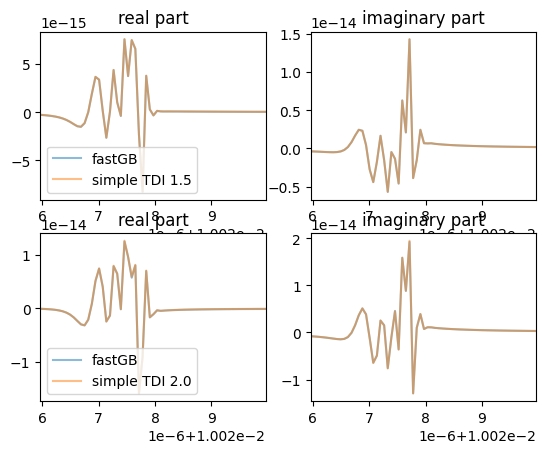

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ldc.lisa.orbits import Orbits
from ldc.waveform.waveform import HpHc
from ldc.lisa.projection import ProjectedStrain
import ldc.io.yml as ymlio
import os
import h5py
import ldc.waveform.fastGB as FB
from ldc.common.series import TimeSeries
from ldc.common import constants

config = {"dt":5.0, "initial_position": 0, "initial_rotation": 0, 
          "nominal_arm_length": 2500000000, "orbit_type": 'analytic', 
          "t_max": 60*60*24*30*6, "t_min": 0, "travel_time_order": 1}

cat = np.array([(4.688322047828039e-21, -0.7072278874089373,
                 3.5318990119515874,
                 0.01002696164199913, 7.0274293836061735e-15,
                 0.8456506362930373, 0.21987979316696454,
                 2.481152331028798)],
               dtype=[('Amplitude', '<f8'),
                      ('EclipticLatitude', '<f8'),
                      ('EclipticLongitude', '<f8'),
                      ('Frequency', '<f8'), ('FrequencyDerivative', '<f8'),
                      ('Inclination', '<f8'), ('InitialPhase', '<f8'),
                      ('Polarization', '<f8')])

GB = HpHc.type("GB", "GB", "TD_fdot")
GB.set_param(cat)
GWs = GB.split()

globals().update(config)
trange = np.arange(t_min, t_max, dt)
orbits = Orbits.type(config)
P = ProjectedStrain(orbits)
yArm = P.arm_response(t_min, t_max, dt, GWs, tt_order=travel_time_order)

simple_tdi_X = P.compute_tdi_x(trange, tdi2=False)
simple_tdi_X = TimeSeries(simple_tdi_X,dt=dt,t0=t_min)
simple_tdi_X = simple_tdi_X.ts.fft()

simple_tdi2_X = P.compute_tdi_x(trange, tdi2=True)
simple_tdi2_X = TimeSeries(simple_tdi2_X, dt=dt,t0=t_min)
simple_tdi2_X = simple_tdi2_X.ts.fft()

GB = FB.FastGB(delta_t=dt, T=t_max)
pGB = dict(zip(cat.dtype.names, cat[0]))
X, Y, Z = GB.get_fd_tdixyz(template=pGB)
X2, Y2, Z2 = GB.get_fd_tdixyz(template=pGB, tdi2=True)


plt.figure()
i = 1
for x, s, g in zip([X, X2], [simple_tdi_X, simple_tdi2_X], ["1.5", "2.0"]):
    plt.subplot(2,2,i)
    plt.title("real part")
    plt.plot(x.f, x.real, alpha=0.5, label="fastGB")
    plt.plot(s.f, s.real, alpha=0.5, label=f"simple TDI {g}")
    plt.axis([pGB["Frequency"]-1e-6, pGB["Frequency"]+3e-6, None, None])
    plt.legend()
    plt.subplot(2,2,i+1)
    plt.title("imaginary part")
    plt.plot(x.f, x.imag, alpha=0.5, label="fastGB")
    plt.plot(s.f, s.imag, alpha=0.5, label=f"simple TDI {g}")
    plt.axis([pGB["Frequency"]-1e-6, pGB["Frequency"]+3e-6, None, None])
    i = i+2




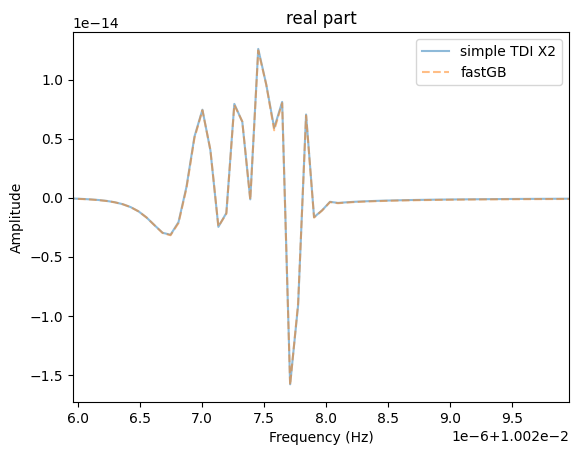

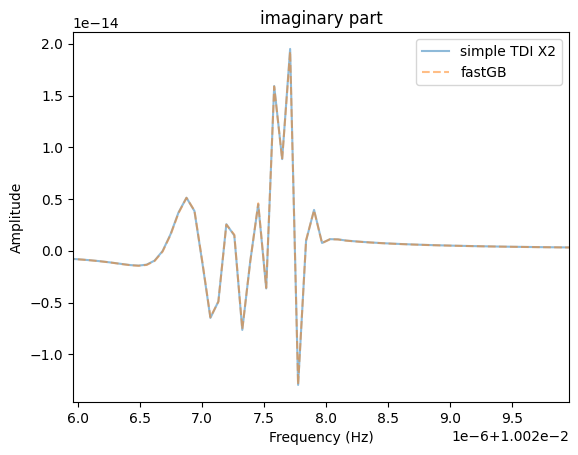

In [23]:
plt.figure()
plt.title("real part")
plt.plot(simple_tdi2_X.f, simple_tdi2_X.real, alpha=0.5, label="simple TDI X2")
plt.plot(X2.f, X2.real, alpha=0.5, label="fastGB",linestyle='dashed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.axis([pGB["Frequency"]-1e-6, pGB["Frequency"]+3e-6, None, None])
plt.legend()
plt.figure()
plt.title("imaginary part")
plt.plot(simple_tdi2_X.f, simple_tdi2_X.imag, alpha=0.5, label="simple TDI X2")
plt.plot(X2.f, X2.imag, alpha=0.5, label="fastGB",linestyle='dashed')
plt.axis([pGB["Frequency"]-1e-6, pGB["Frequency"]+3e-6, None, None])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()


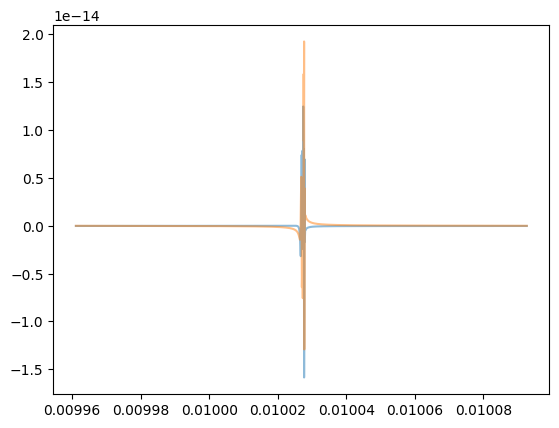

In [10]:
plt.figure()
plt.subplot(1,2)
plt.plot(X2.f, X2.real, alpha=0.5, label="fastGB")
plt.plot(X2.f, X2.imag, alpha=0.5, label=f"simple TDI {g}")


In [2]:
#SourceParameters

#def chi_f(alpha_f,m):
#        return (4*alpha_f*m)/(4*alpha_f*m+m)
    
def func_h0(M,alpha,chi,chi_f):
    return(8e-28/10)*(M)*(alpha/0.1)**7*((chi-chi_f)/0.1)

def func_freq(M,alpha):
    return (645)*(10/M)*(alpha/0.1)

def func_fdot(M,alpha,chi):
    return 3e-14*(10**2/M)**2*(alpha/0.1)**19*chi**2

def param(M,alpha,chi,chi_f):
    tab=[]
    h0=func_h0(M,alpha,chi,chi_f)
    
    long=np.random.uniform(-np.pi,np.pi)
    lat=np.random.uniform(-np.pi/2,np.pi/2)
    
    f=func_freq(M,alpha)
    fdot=func_fdot(M,alpha,chi)
    
    inc=np.arccos(np.random.uniform(-1,1))
    initialPhase=np.random.uniform(0,2*np.pi)
    pol=np.random.uniform(0,2*np.pi)
    
    tab=(h0,long,lat,f,fdot,inc,initialPhase,pol)
    return tab


tab_Param=param(M=10**6,alpha=0.12,chi=0.5,chi_f=0.45)
print(tab_Param)

(1.4332723199999993e-22, -1.7597149468101336, -0.5861488484892567, 0.00774, 2.3960999952796703e-21, 1.9400405841318973, 1.1033871596995943, 5.077702836721466)


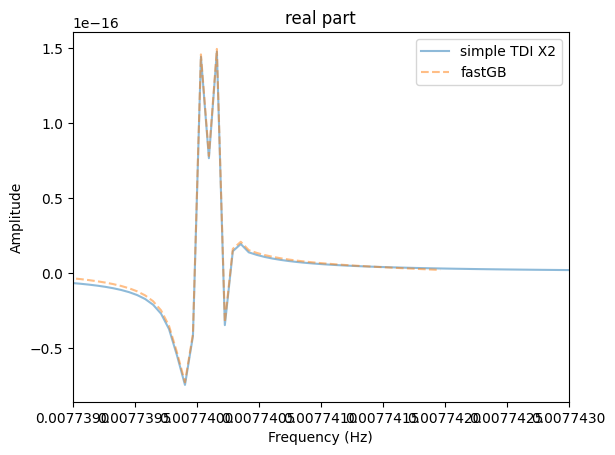

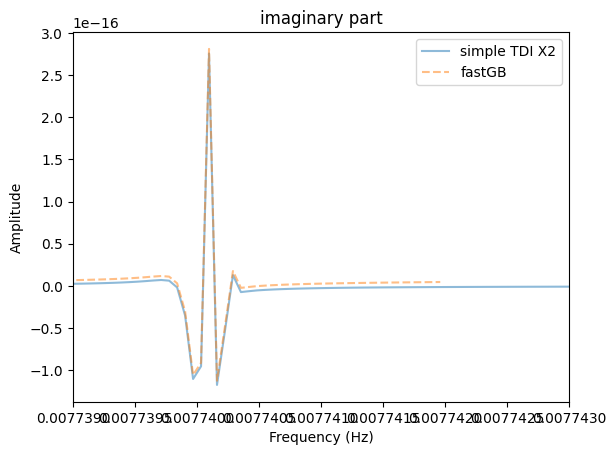

In [5]:
cat = np.array([tab_Param],
               dtype=[('Amplitude', '<f8'),
                      ('EclipticLatitude', '<f8'),
                      ('EclipticLongitude', '<f8'),
                      ('Frequency', '<f8'), ('FrequencyDerivative', '<f8'),
                      ('Inclination', '<f8'), ('InitialPhase', '<f8'),
                      ('Polarization', '<f8')])

GB = HpHc.type("GB", "GB", "TD_fdot")
GB.set_param(cat)
GWs = GB.split()

globals().update(config)
trange = np.arange(t_min, t_max, dt)
orbits = Orbits.type(config)
P = ProjectedStrain(orbits)
yArm = P.arm_response(t_min, t_max, dt, GWs, tt_order=travel_time_order)

simple_tdi_X = P.compute_tdi_x(trange, tdi2=False)
simple_tdi_X = TimeSeries(simple_tdi_X,dt=dt,t0=t_min)
simple_tdi_X = simple_tdi_X.ts.fft()

simple_tdi2_X = P.compute_tdi_x(trange, tdi2=True)
simple_tdi2_X = TimeSeries(simple_tdi2_X, dt=dt,t0=t_min)
simple_tdi2_X = simple_tdi2_X.ts.fft()

GB = FB.FastGB(delta_t=dt, T=t_max)
pGB = dict(zip(cat.dtype.names, cat[0]))
X, Y, Z = GB.get_fd_tdixyz(template=pGB)
X2, Y2, Z2 = GB.get_fd_tdixyz(template=pGB, tdi2=True)

plt.figure()
plt.title("real part")
plt.plot(simple_tdi2_X.f, simple_tdi2_X.real, alpha=0.5, label="simple TDI X2")
plt.plot(X2.f, X2.real, alpha=0.5, label="fastGB",linestyle='dashed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.axis([pGB["Frequency"]-1e-6, pGB["Frequency"]+3e-6, None, None])
#plt.xlim([0.007735,0.0077410])
plt.legend()
plt.figure()
plt.title("imaginary part")
plt.plot(simple_tdi2_X.f, simple_tdi2_X.imag, alpha=0.5, label="simple TDI X2")
plt.plot(X2.f, X2.imag, alpha=0.5, label="fastGB",linestyle='dashed')
plt.axis([pGB["Frequency"]-1e-6, pGB["Frequency"]+3e-6, None, None])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
#plt.xlim([0.007735,0.0077410])
plt.legend()


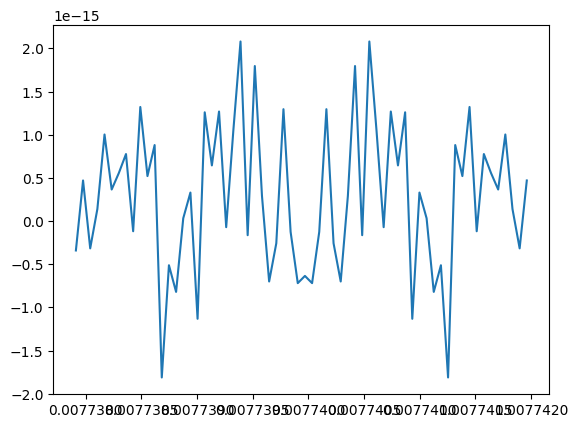

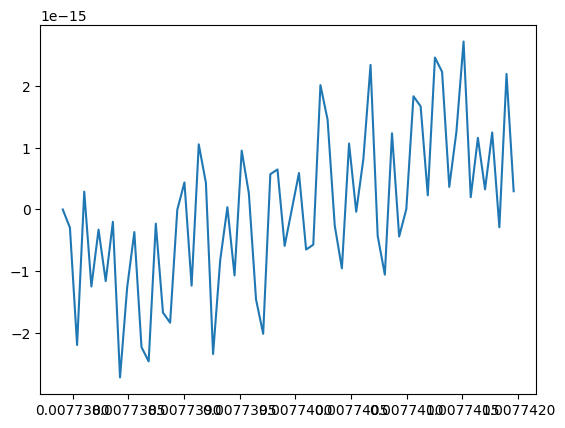

In [87]:
#Noiseinjection
sigma=2e-16
n = np.random.normal(0,sigma,size=len(X2.f))

plt.plot((X2.f),np.fft.fft((n)).real)
plt.figure()
plt.plot(X2.f, np.fft.fft((n)).imag)

In [73]:
simple_tdi2_Xa = P.compute_tdi_x(trange, tdi2=True)
simple_tdi2_Xb = TimeSeries(simple_tdi2_X, dt=dt,t0=t_min)
#print(yArm)
#print(simple_tdi2_Xa)
print(len(simple_tdi2_Xa))
print(type(simple_tdi2_Xb))


3110400
<class 'xarray.core.dataarray.DataArray'>


In [75]:
print(simple_tdi2_Xb)

<xarray.DataArray (t: 1555201)>
array([4.61939598e-21+0.00000000e+00j, 4.61939598e-21-4.60307689e-27j,
       4.61939598e-21-9.20615543e-27j, ...,
       7.37161348e-22-1.24757951e-27j, 7.37161012e-22-5.07152536e-28j,
       7.37160734e-22+0.00000000e+00j])
Coordinates:
  * t        (t) float64 0.0 5.0 10.0 15.0 ... 7.776e+06 7.776e+06 7.776e+06
Attributes:
    units:    None
    t0:       0
    dt:       5.0


In [83]:
print(simple_tdi2_Xb.attrs)
print(simple_tdi2_Xb.values)
print(simple_tdi2_Xb.coords)
(type(simple_tdi2_Xb.coords))

{'units': None, 't0': 0, 'dt': 5.0}
[4.61939598e-21+0.00000000e+00j 4.61939598e-21-4.60307689e-27j
 4.61939598e-21-9.20615543e-27j ... 7.37161348e-22-1.24757951e-27j
 7.37161012e-22-5.07152536e-28j 7.37160734e-22+0.00000000e+00j]
Coordinates:
  * t        (t) float64 0.0 5.0 10.0 15.0 ... 7.776e+06 7.776e+06 7.776e+06


xarray.core.coordinates.DataArrayCoordinates

64


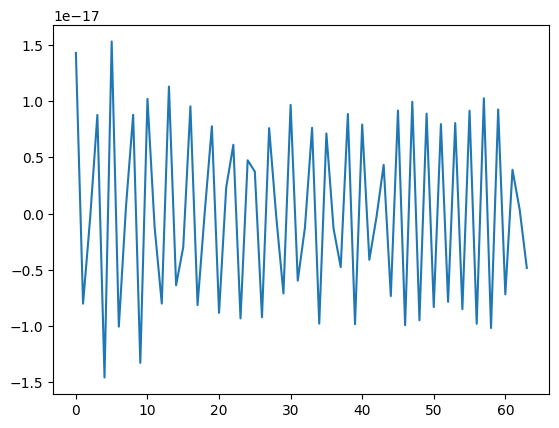

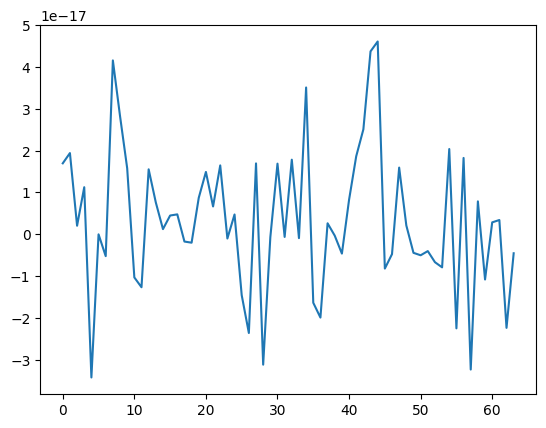

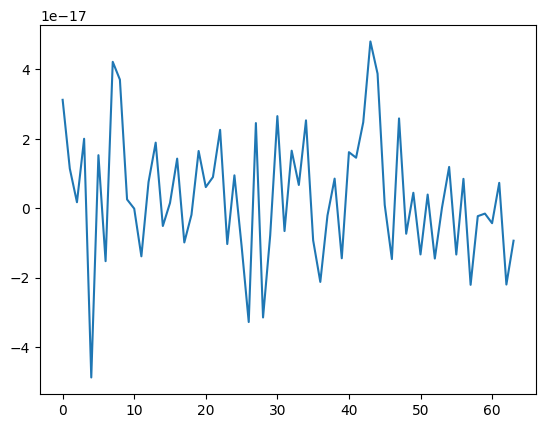

In [114]:
X2_temp=np.fft.ifft(X2)
print(len(X2_temp))
noise=np.random.normal(0,0.1,size=len(X2_temp))
d=X2_temp+noise
plt.figure()
plt.plot(X2_temp)
plt.figure()
plt.plot(noise)
plt.figure()
plt.plot(d)


/tmp/ipykernel_873998/2212184699.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  d.append(X2_temp[i]+np.random.normal(X2_temp[i],0.1,))


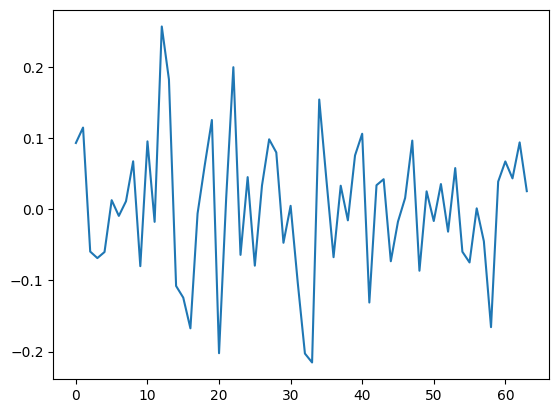

In [129]:
d=[]
for i in range (len(X2_temp)):
    d.append(X2_temp[i]+np.random.normal(X2_temp[i],0.1,))
    
plt.plot(d)



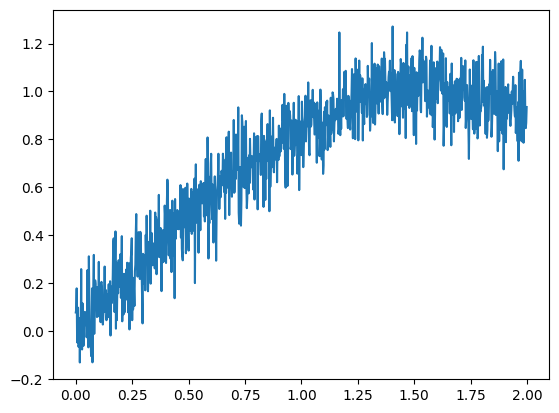

In [173]:
def aleaGauss(sigma):
    U1 = np.random.uniform()
    U2 = np.random.uniform()
    return sigma*math.sqrt(-2*math.log(U1))*math.cos(2*math.pi*U2) 

def signal(t):
    return np.sin(t)
N=1000
T=2
dt = T/N
y = np.zeros(N)
t = np.zeros(N)
sigma = 0.1
for k in range(N):
    t[k] = k*dt
    y[k] = signal(t[k])+np.random.normal(0,0.1)
    #y[k] = signal(t[k])
plt.plot(t,y)


In [6]:
X2_t,Y2_t,Z2_t=GB.get_td_tdixyz(template=pGB,tdi2=True)

3110399


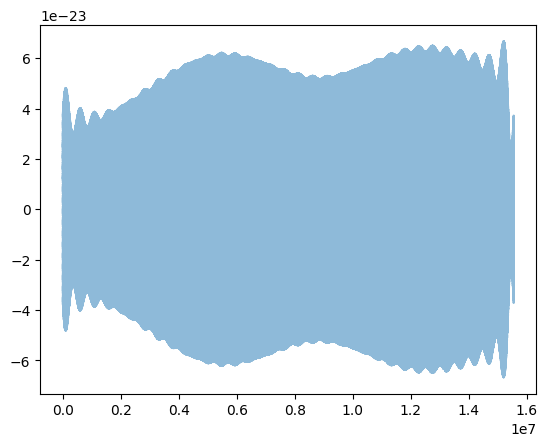

In [61]:
plt.plot(X2_t.t, X2_t, alpha=0.5, label="fastGB",linestyle='dashed')
#plt.axis(1/[pGB["Frequency"]-1e-6, 1/pGB["Frequency"]+3e-6, None, None])
print(len(X2_t))

5.069446074281788
3110399


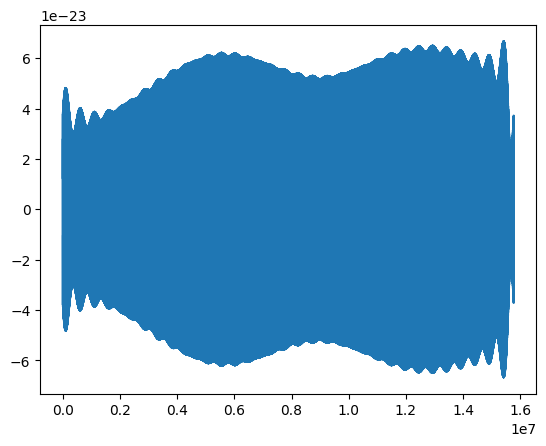

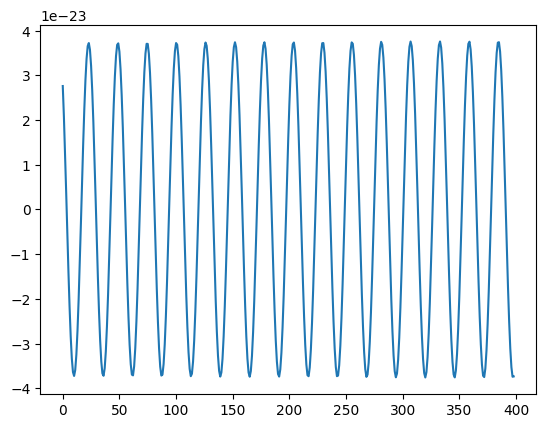

In [9]:
N=len(X2_t)
Tobs = 365*24*60*60*0.5
T=Tobs
dt=T/N

t= np.arange(0, Tobs,T/N)
plt.plot(t,X2_t)
print(dt)
print(len(t))
plt.figure()
plt.plot(X2_t[:-3110000])

In [46]:
from math import modf
N=len(X2_t)
T=Tobs
dt=int(T/N)
d = np.zeros(N)
t = np.zeros(N)
sigma = 0.1

print(dt)
print(N)
for k in range(N-1):
    t[k]=k*dt
    part_float, part_int = modf(t[k])
    t[k]=int(part_int)
    
print(t[k])

a = 2.751
part_entiere = int(str(a).split(".")[0])
part_decimale = int(str(a).split(".")[1])



5
3110399
15551985.0


3110398


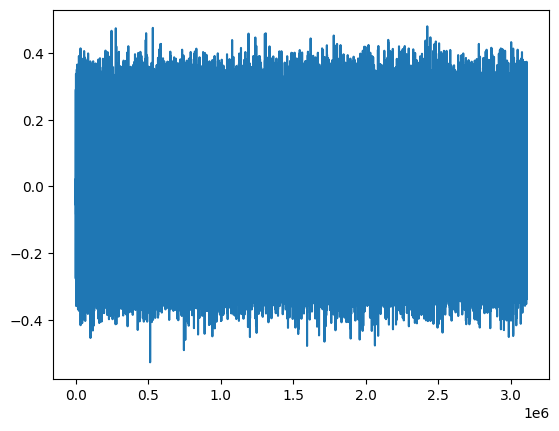

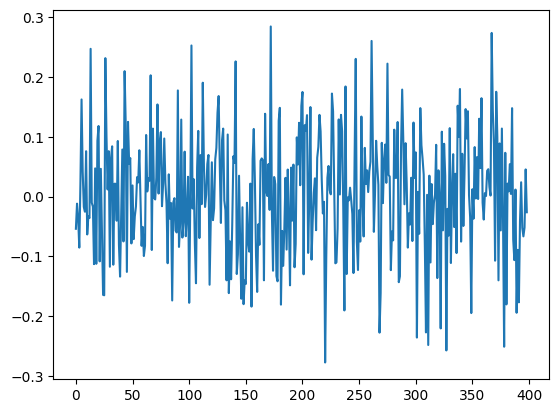

In [51]:
N=len(X2_t)
T=Tobs
dt=
d = np.zeros(N)
t = np.zeros(N)
sigma = 0.1

for k in range(N):
    t[k] = k*dt
    part_entiere = int(str(t[k]).split(".")[0])
    part_decimale = int(str(t[k]).split(".")[1])
    t[k]=part_entiere
    
    d[k] = X2_t[int(t[k])]+np.random.normal(0,0.1)
plt.plot(t,d)
plt.figure()
plt.plot(d[:-3110000])
print(int(t[k]))

In [62]:
dt=T/N
print((dt))

5.069446074281788


In [88]:
import ldc
from ldc.lisa.noise import get_noise_model
from ldc.lisa.noise import NumericNoise
AddLDC = True

import backgroundsmaster
from backgroundsmaster.backgrounds.utils import generate_noise
generate_noise

f_sampling=1/dt
#get_noise_model("SciRDv1",f).psd(option='X',tdi2=True)

c=3e8
L_m = 2.5e9
L = L_m/c
#omegaL = 2*np.pi*f*L
f1=0.4e-3
def Sn_X2(f):
    S_I=5.76e-48*(1*(f1/f)**2)
    S_II=3.6e-41
    return (4*np.pi*f*L)**2*(np.sin(2*np.pi*f*L))**2*(2*np.sin(2*np.pi*f*L))**2*(S_I/(2*np.pi*f)**4)+S_II

time_series=generate_noise(psd_func=Sn_X2, n_data=N, fs=f_sampling)

In [91]:
print(time_series)
print(len(time_series))

[-4.42159143e-21 -3.83995716e-22 -3.45041324e-22 ... -1.07632053e-21
  2.26998623e-21  4.31791522e-21]
3110399
